# **Baseline** 

In [1]:
## import
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from utils import load_data_for_mnist, nbr_total_pred
import mnist_classifier_config
from torchsummary import summary

In [2]:
#data loading
dloader_train, dloader_test = load_data_for_mnist()
print(f'num_imgs_per_category: {mnist_classifier_config.data_train_opt["num_imgs_per_cat"]}')
print(f"nimber total of label data: {len(dloader_train.dataset.data.targets)}")

num_imgs_per_category: 10
nimber total of label data: 100


/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/bdiarra/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
## model creation**
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
network = Net()
if torch.cuda.is_available():
    network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.003)

In [ ]:
## training and testing**
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

# loss function
cross_entropy_loss = torch.nn.NLLLoss()
# number of epoch
nb_epoch = 10


def train(epoch):
    network.train()
    epoch_loss = []
    total_label = 0
    total_correct_pred = 0
    for _, batch in enumerate(tqdm(dloader_train(epoch), ascii=True, desc=f"epoch_{epoch + 1}/{nb_epoch}")):
        dataX = torch.FloatTensor()
        labels = torch.LongTensor()
        dataX.resize_(batch[0].size()).copy_(batch[0])
        labels.resize_(batch[1].size()).copy_(batch[1])

        dataX_var = torch.autograd.Variable(dataX)
        labels_var = torch.autograd.Variable(labels, requires_grad=False)
        if torch.cuda.is_available():
            dataX_var = dataX_var.cuda()
            labels_var = labels_var.cuda()
        pred_var = network(dataX_var)

        # compute the loss
        loss = cross_entropy_loss(pred_var, labels_var)
        epoch_loss.append(loss.item())

        # compute the number of correct prediction
        total_correct_pred += nbr_total_pred(pred_var, labels_var)
        total_label += labels_var.size(0)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    accuracy = 100.0 * total_correct_pred / total_label
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    # create checkpoint (it will be use later for transfer learning stage)
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss[-1]
        }, f"./models_save_dir/baseline/model_epoch_{epoch + 1}"
    )

    print(f"Train Loss: {epoch_loss} | Accuracy: {accuracy} %")


def test(epoch):
    network.eval()
    with torch.no_grad():
        epoch_loss = []
        total_label = 0
        total_correct_pred = 0
        for _, batch in enumerate(tqdm(dloader_test(epoch), ascii=True, desc=f"Test of epoch_{epoch + 1}")):
            dataX = torch.FloatTensor()
            labels = torch.LongTensor()
            dataX.resize_(batch[0].size()).copy_(batch[0])
            labels.resize_(batch[1].size()).copy_(batch[1])
            dataX_var = torch.autograd.Variable(dataX)
            labels_var = torch.autograd.Variable(labels, requires_grad=False)
            if torch.cuda.is_available():
                dataX_var = dataX_var.cuda()
                labels_var = labels_var.cuda()
            pred_var = network(dataX_var)

            # compute the loss
            loss = cross_entropy_loss(pred_var, labels_var)
            epoch_loss.append(loss.item())

            # compute the number of correct prediction
            total_correct_pred += nbr_total_pred(pred_var, labels_var)
            total_label += labels_var.size(0)
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        accuracy = 100.0 * total_correct_pred / total_label
        test_loss.append(epoch_loss)
        test_accuracy.append(accuracy)

        print(f"Test Loss: {epoch_loss} | Accuracy: {accuracy} %")


def fit(nb_epoch):
    for epoch in range(nb_epoch):
        train(epoch)
        test(epoch)


fit(nb_epoch)

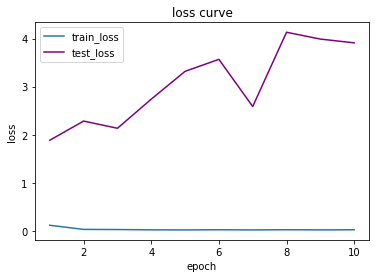

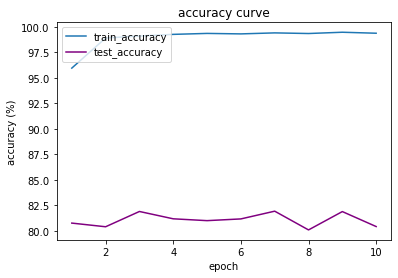

In [6]:
## visualise train loss and accuracy plot
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_loss, label='train_loss')
fig = plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), test_loss, label='test_loss', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("loss curve")
plt.savefig('./figs/loss_curve_baseline')
plt.show()
print()
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_accuracy, label='train_accuracy')
plt.plot(np.linspace(1, nb_epoch,nb_epoch).astype(int), test_accuracy, label='test_accuracy', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title("accuracy curve")
plt.savefig('./figs/accuracy_curve_baseline')
plt.show()

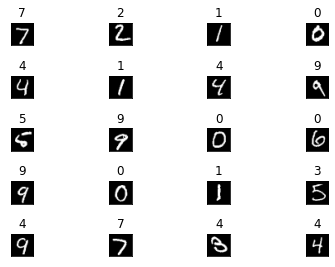

In [8]:
# prediction after training
for b in dloader_test(0):
    data, label = b
    break

inv_transform = dloader_train.inv_transform

if torch.cuda.is_available():
    data_cuda = data.cuda()
else:
    data_cuda = data
network.eval()
with torch.no_grad():
    _, pred = network(data_cuda).data.max(1)

    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.tight_layout()
        plt.title(f"{pred[i].item()}")
        fig = plt.imshow(inv_transform(data[i]).squeeze(), cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.savefig(
        f'./figs/basline_img_4x4_pred_after_training_with_{mnist_classifier_config.data_train_opt["num_imgs_per_cat"]}')
    plt.show()